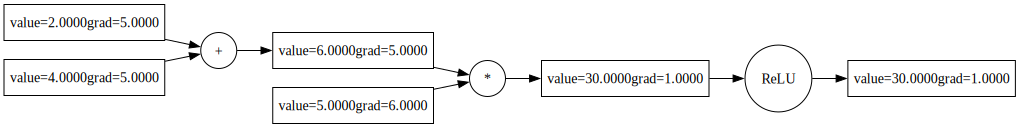

In [7]:
#I'm going to create a simple graph which will have nodes and edges, be able to do derivatives and thus backpropagation.
#which will be visualized using graphviz.


#things that need to be implemented : 
'''
layers of neurons 
mlp
loss function 
ways to interate
'''
from graphviz import Digraph


def trace(root): #this is a DFS to get all nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        # value node (box)
        dot.node(uid, label=f"value={n.value:.4f}\ngrad={n.grad:.4f}", shape="record")

        # op node (small circle) if this node was produced by an op
        if n.op:
            op_id = uid + n.op
            dot.node(op_id, label=n.op, shape="circle")
            dot.edge(op_id, uid)  # op -> value

    # connect children -> op node (if present), else children -> value node
    for a, b in edges:
        b_uid = str(id(b))
        if b.op:
            dot.edge(str(id(a)), b_uid + b.op)  # child -> op
        else:
            dot.edge(str(id(a)), b_uid)         # leaf case

    return dot

class Node:
    def __init__(self, value, children=(), op=''):
        self.value = value
        self.grad = 0.0
        self._backward = lambda: None
        self.children = children
        self.op = op

    def __add__(self, other):   
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value + other.value, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value - other.value, (self, other), '-')
        def _backward(): 
            self.grad += out.grad
            other.grad += -1*out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value * other.value, (self, other), '*')    
        def _backward(): 
            self.grad += out.grad*other.value
            other.grad += out.grad*self.value
        out._backward = _backward
        return out
    
    def __repr__(self):
        return f"Node(value={self.value}, grad={self.grad}, op='{self.op}')"
    
    def relu(self):
        out = Node(0.0 if self.value < 0 else self.value, (self,), 'ReLU')

        def _backward():
            # d/dx ReLU(x) = 1 if x > 0 else 0
            self.grad += (out.value > 0) * out.grad

        out._backward = _backward
        return out
    
    
    def backward(self):
        visited = set()
        topo = []

        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build(child)
                topo.append(v)

        build(self)

        self.grad = 1.0  # seed here

        for node in reversed(topo):
            node._backward()

    def zero_grad(self):
        nodes, _ = trace(self)
        for n in nodes:
            n.grad = 0.0



n1 = Node(2)
n2 = Node(4)
n3 = n1 + n2
n4 = Node(5)
n5 = n3*n4
L = n5.relu()

#i will call the above a branch 
#i need to make the tree and hence the forest 

#end goal : given an array xs = [1.0,1.5,2.3,3.0] which is basically a vector
# i will feed this into model(xs) which will intake one entry individually 
# and outputs outs = [?,?,?,?] which will be compared to truths [2.0,1.0,2.8,2.5]
# and will train weights to get similar values to the truths 

#the model will accept the input node, multiply by weight #00, add bias #00 
#will have a first layer of 4 neurons which will multipy output of input node by their respective weights 
# #10, #11, #12, #13 with and add their respective biases. #10, #11, #12, #13 
# a second layer which has 16 neuros with weights #20~#215 where #20 will recieve outputs from #10 and #10
# #21 will accept outputs from #10 and #11 ~ #23 will recieve data from #10 and #13 
# finally #15 will recieve outputs from #13 and #13. 
# they will all output to a single node via summation and then use relu 
# output relu and do rms with the actual (truths - outs)^2 = rms^2. 

#we then use backward to get grads. and print weights and biases. (for the weight nodes only) 
# alter the weights += -0.1*grad

#keep on printing the rms^2 value for a lot of times and see if it converges 





L.zero_grad()
L.backward()
dot = draw_dot(L)
dot


In [12]:
import random
from matplotlib.pyplot import draw

class Neuron:
    def __init__(self, nin):
        self.weight = [Node(random.uniform(-1,1)) for n in range(nin)]
        self.dim = nin
        self.bias = Node(0.0)

    def __call__(self, xss):
        xs = [xi if isinstance(xi,Node) else Node(xi) for xi in xss]
        #meaning xs = [x1,x2,..,xn] if xi is not Node make Node(xi) 
        out = self.bias
        for xi,wi in zip(self.weight,xs):
            out = out + xi*wi
        #meaing out (which is a node) is defined as the b + x1*w1 + x2*w2 + ... xn*wn
            
        return out.relu()

    def parameters(self):
        return self.weight + [self.bias]


#so neurons accept nin Neuron(nin) to initalize e.g. n = Neuron(3)
#and when we do n([1,2,3]) for ex. it makes and n = out = b + 1*w1 + 2*w2 + 3*w3 



n = Neuron(3)
xs = [1.0,2.0,3.0]
out = n(xs)

print(out)
"""
dot = draw_dot(out)
dot"""



Node(value=2.64204944709016, grad=0.0, op='ReLU')


'\ndot = draw_dot(out)\ndot'

In [18]:


# now for layers recall layers are just groups of Neurons so


class layers:
    def __init__(self,nin,nly):
        self.neurons = [Neuron(nin) for layers in range(nly)]

    def __call__(self, xs):
        xs = [xi if isinstance(xi,Node) else Node(xi) for xi in xs]
        outs = [n(xs) for n in self.neurons]
        return outs
    
    def parameters(self):
        params = []
        for n in self.neurons:
            params += n.parameters()
        return params
        
# what this does, instantiate with layers(nin,nly)
#where nin is the input dim 
#nly is the number of neurons for this layer 
"""
layer = layers(3,4)
xs = [1.0,2.0,3.0]
outs = layer(xs)
s = outs[0]

for o in outs[1:]:
    s = s + o

print(s)

dot = draw_dot(s)
dot

        
"""




'\nlayer = layers(3,4)\nxs = [1.0,2.0,3.0]\nouts = layer(xs)\ns = outs[0]\n\nfor o in outs[1:]:\n    s = s + o\n\nprint(s)\n\ndot = draw_dot(s)\ndot\n\n\n'

In [19]:

# now the above is a single layer, we now need a multi-layer. we will then see what else we must add
# for the mlp we need to do a lot of cross additions. 

#first instantiate the first layer which is a single neuron layer 
#then output into the second layer which will have 4 neurons  which accepts out from the pervious layer 
#will do the classical wi*out_1 + bias 
# the third layer will do dot products between the 4 neurons in the second layer 
#ex, N21 * N21, N21*N22,...,N24*N24 so there needs to be 16 neurons in the third layer 
#then add all outputs like we did before 
"""
layout = 4
class multilayer:
    def __init__(self,layout, nin): #layout refers to number of layers in the MLP
        self.layer = [layers(nin,layout_i) for layout_i in layout]


    def __call__(self,xs):
        xs = [xi if isinstance(xi,Node) else Node(xi) for xi in xs]
        #for depth = len(layout)
        
"""

class MLP:
    def __init__(self, nin, layout):
        # layout like [1, 4, 16] etc.
        sz = [nin] + list(layout)
        self.layers = [layers(sz[i], sz[i+1]) for i in range(len(layout))]

    def __call__(self, xs):
        # xs can be list of floats or Nodes
        for layer in self.layers:
            xs = layer(xs)   # layer returns a list of Nodes
        return xs

    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params




In [28]:
net = MLP(nin=4, layout=[1, 4, 16, 16, 16, 4])   # R³ → R → R⁴ → R¹⁶ → R
xs = [1.0, 2.0, 3.0, 4.0]
y_pred = net(xs)     
target = [2.0,4.0,6.0,8.0]
loss = Node(0.0)
for yp, yt in zip(y_pred, target):
    loss = loss + (yp - yt) * (yp - yt)

loss.backward()

lr = 0.001
for p in net.parameters():
    p.value -= lr * p.grad
    p.grad = 0.0

for step in range(2000):
    x = [random.uniform(-1,1) for _ in range(3)]
    y = x[0]*x[1] + x[2]**2   # nonlinear target

    y_pred = net(x)[0]
    loss = (y_pred - y) * (y_pred - y)
    loss.zero_grad()
    loss.backward()

    for p in net.parameters():
        p.value -= 0.01 * p.grad
        p.grad = 0.0

    if step % 200 == 0:
        print(step, loss.value)



0 0.3842609675027565
200 0.03993319813304521
400 0.09374874794704686
600 1.420542553646582
800 0.0027646679776329886
1000 0.11893974004491342
1200 0.016556032999357578
1400 0.2240699314682247
1600 0.0275708145556951
1800 0.2794173956542341


In [30]:
test = [1.0,2.0,3.0,4.0]
pred2 = net(test)
print([p.value for p in pred2])

[0.0, 0.0, 0.0, 0.0]
